# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

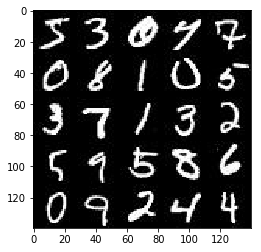

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

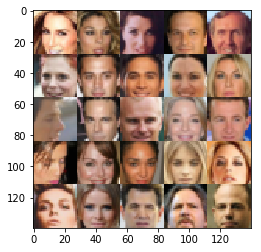

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


C:\Anaconda3\envs\tensorflow_cpu\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits
    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    _, img_width, img_height, img_channels = data_shape
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.1994... Generator Loss: 3.9310
Epoch 1/2... Discriminator Loss: 2.3873... Generator Loss: 8.8179
Epoch 1/2... Discriminator Loss: 0.2633... Generator Loss: 2.6507
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 0.2584... Generator Loss: 2.3764
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 9.2994
Epoch 1/2... Discriminator Loss: 0.5192... Generator Loss: 1.3431
Epoch 1/2... Discriminator Loss: 0.1146... Generator Loss: 5.6596
Epoch 1/2... Discriminator Loss: 0.4628... Generator Loss: 4.5487
Epoch 1/2... Discriminator Loss: 0.6329... Generator Loss: 1.1266


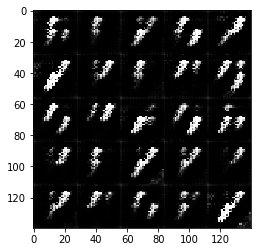

Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 4.4378
Epoch 1/2... Discriminator Loss: 0.7608... Generator Loss: 1.5762
Epoch 1/2... Discriminator Loss: 0.4960... Generator Loss: 1.8535
Epoch 1/2... Discriminator Loss: 0.7467... Generator Loss: 1.9048
Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 1.0195
Epoch 1/2... Discriminator Loss: 0.4161... Generator Loss: 6.2858
Epoch 1/2... Discriminator Loss: 1.4314... Generator Loss: 0.5430
Epoch 1/2... Discriminator Loss: 0.6530... Generator Loss: 1.2072
Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 1.4274
Epoch 1/2... Discriminator Loss: 1.6363... Generator Loss: 0.3317


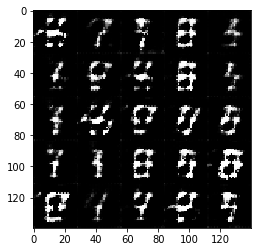

Epoch 1/2... Discriminator Loss: 0.1938... Generator Loss: 2.9309
Epoch 1/2... Discriminator Loss: 2.3224... Generator Loss: 6.0204
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 1.0820
Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 3.4006
Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 2.5713
Epoch 1/2... Discriminator Loss: 0.3338... Generator Loss: 2.2273
Epoch 1/2... Discriminator Loss: 3.2598... Generator Loss: 6.9532
Epoch 1/2... Discriminator Loss: 0.7508... Generator Loss: 1.3857
Epoch 1/2... Discriminator Loss: 0.3023... Generator Loss: 2.7252
Epoch 1/2... Discriminator Loss: 0.5681... Generator Loss: 1.7462


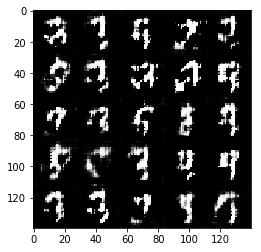

Epoch 1/2... Discriminator Loss: 0.5140... Generator Loss: 3.4012
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 1.5627
Epoch 1/2... Discriminator Loss: 0.2672... Generator Loss: 2.5807
Epoch 1/2... Discriminator Loss: 0.4886... Generator Loss: 1.5903
Epoch 1/2... Discriminator Loss: 0.6734... Generator Loss: 2.9542
Epoch 1/2... Discriminator Loss: 0.7215... Generator Loss: 2.3129
Epoch 1/2... Discriminator Loss: 1.4486... Generator Loss: 0.6004
Epoch 1/2... Discriminator Loss: 0.4183... Generator Loss: 2.0564
Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.6066... Generator Loss: 0.3871


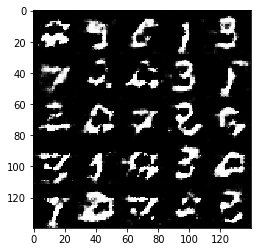

Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 0.8266
Epoch 1/2... Discriminator Loss: 0.8273... Generator Loss: 2.1849
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 1.7120
Epoch 1/2... Discriminator Loss: 0.6493... Generator Loss: 1.1982
Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 1.1877
Epoch 1/2... Discriminator Loss: 0.9153... Generator Loss: 1.4649
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 2.5154
Epoch 1/2... Discriminator Loss: 0.8805... Generator Loss: 0.9199
Epoch 1/2... Discriminator Loss: 0.7655... Generator Loss: 1.4015
Epoch 1/2... Discriminator Loss: 1.7288... Generator Loss: 2.9846


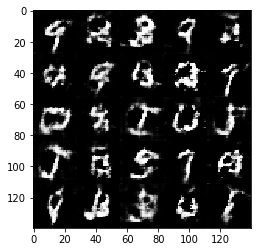

Epoch 1/2... Discriminator Loss: 0.7565... Generator Loss: 1.4900
Epoch 1/2... Discriminator Loss: 0.9805... Generator Loss: 0.9434
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 1.4417
Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 0.7809
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.6090
Epoch 1/2... Discriminator Loss: 0.7731... Generator Loss: 1.0916
Epoch 1/2... Discriminator Loss: 0.6080... Generator Loss: 1.6976
Epoch 1/2... Discriminator Loss: 0.6634... Generator Loss: 2.2556


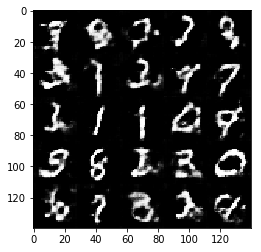

Epoch 1/2... Discriminator Loss: 0.9142... Generator Loss: 1.1194
Epoch 1/2... Discriminator Loss: 0.7771... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 0.8027... Generator Loss: 1.1650
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 0.8000... Generator Loss: 1.9580
Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 0.6552
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 0.6994
Epoch 1/2... Discriminator Loss: 0.8162... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 2.5094


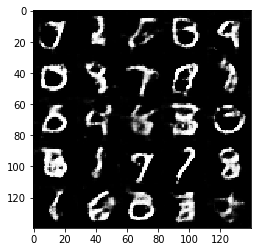

Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 1.5544
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 0.9497... Generator Loss: 0.8297
Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 1.7440
Epoch 1/2... Discriminator Loss: 0.7113... Generator Loss: 1.3366
Epoch 1/2... Discriminator Loss: 0.7629... Generator Loss: 1.1511
Epoch 1/2... Discriminator Loss: 0.9134... Generator Loss: 2.1631
Epoch 1/2... Discriminator Loss: 0.8861... Generator Loss: 0.8496
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 1.0678


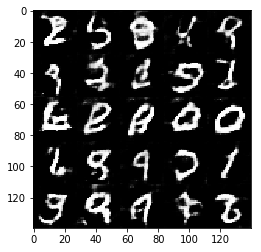

Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 0.5664... Generator Loss: 1.1104
Epoch 1/2... Discriminator Loss: 2.0415... Generator Loss: 0.2420
Epoch 1/2... Discriminator Loss: 1.0318... Generator Loss: 0.8170
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 0.7479
Epoch 1/2... Discriminator Loss: 2.1242... Generator Loss: 2.1863
Epoch 1/2... Discriminator Loss: 0.6681... Generator Loss: 1.0712
Epoch 1/2... Discriminator Loss: 0.9281... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 1.3307... Generator Loss: 0.5311


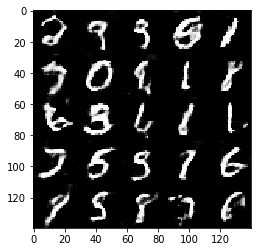

Epoch 1/2... Discriminator Loss: 0.7886... Generator Loss: 1.0098
Epoch 1/2... Discriminator Loss: 1.9210... Generator Loss: 0.2709
Epoch 1/2... Discriminator Loss: 1.3721... Generator Loss: 0.4781
Epoch 2/2... Discriminator Loss: 0.9781... Generator Loss: 0.7430
Epoch 2/2... Discriminator Loss: 0.8807... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 0.7734
Epoch 2/2... Discriminator Loss: 0.8878... Generator Loss: 1.1704
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 2.6587
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 0.7058


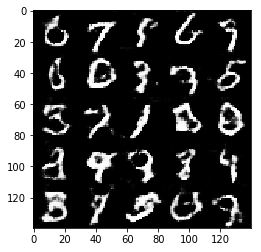

Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 0.6877
Epoch 2/2... Discriminator Loss: 0.8539... Generator Loss: 0.8536
Epoch 2/2... Discriminator Loss: 0.5709... Generator Loss: 1.4549
Epoch 2/2... Discriminator Loss: 1.7412... Generator Loss: 0.3341
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 0.6959
Epoch 2/2... Discriminator Loss: 0.8218... Generator Loss: 1.3956
Epoch 2/2... Discriminator Loss: 0.7974... Generator Loss: 1.2262
Epoch 2/2... Discriminator Loss: 2.0758... Generator Loss: 0.2641
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.5362
Epoch 2/2... Discriminator Loss: 1.5467... Generator Loss: 2.4363


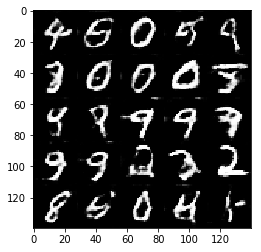

Epoch 2/2... Discriminator Loss: 0.8690... Generator Loss: 1.6281
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.1499
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 1.1760
Epoch 2/2... Discriminator Loss: 0.9098... Generator Loss: 1.5004
Epoch 2/2... Discriminator Loss: 0.9224... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 2.0244
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 1.0561
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 1.5881... Generator Loss: 0.3513
Epoch 2/2... Discriminator Loss: 1.6328... Generator Loss: 0.4179


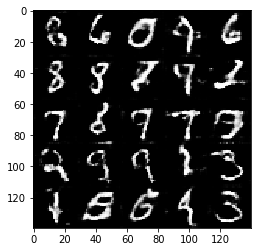

Epoch 2/2... Discriminator Loss: 2.5230... Generator Loss: 0.1317
Epoch 2/2... Discriminator Loss: 1.0049... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 1.1061... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 1.1576... Generator Loss: 0.6858
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.4139
Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 0.5619
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.5361
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.4182
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 0.7844
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 1.2150


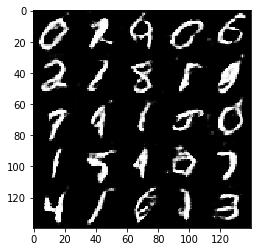

Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 2.8637... Generator Loss: 3.9605
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.3284
Epoch 2/2... Discriminator Loss: 0.7118... Generator Loss: 1.0757
Epoch 2/2... Discriminator Loss: 1.4211... Generator Loss: 0.6424
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.4917
Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 0.7326
Epoch 2/2... Discriminator Loss: 0.6996... Generator Loss: 1.1140
Epoch 2/2... Discriminator Loss: 0.6966... Generator Loss: 1.9120
Epoch 2/2... Discriminator Loss: 1.4017... Generator Loss: 1.9264


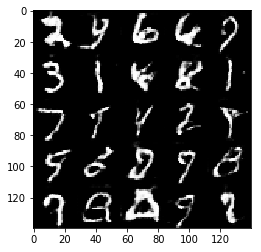

Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.1226
Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 2.2995
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 0.7518
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 0.8697
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 1.2014
Epoch 2/2... Discriminator Loss: 1.5680... Generator Loss: 0.4366
Epoch 2/2... Discriminator Loss: 1.2404... Generator Loss: 0.4716
Epoch 2/2... Discriminator Loss: 0.9899... Generator Loss: 0.7640
Epoch 2/2... Discriminator Loss: 0.9811... Generator Loss: 2.8305
Epoch 2/2... Discriminator Loss: 0.5751... Generator Loss: 1.9229


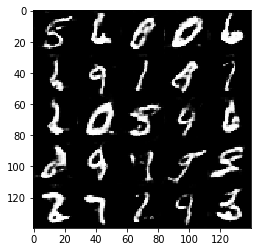

Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 0.5961
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.4825
Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 1.6849
Epoch 2/2... Discriminator Loss: 0.5423... Generator Loss: 1.5261
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.9621... Generator Loss: 4.5164
Epoch 2/2... Discriminator Loss: 1.5948... Generator Loss: 0.4738
Epoch 2/2... Discriminator Loss: 0.6799... Generator Loss: 1.1274
Epoch 2/2... Discriminator Loss: 0.9127... Generator Loss: 1.1362
Epoch 2/2... Discriminator Loss: 2.1339... Generator Loss: 0.2355


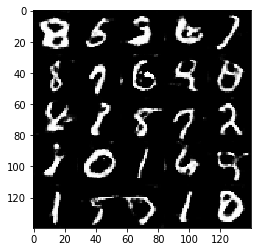

Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 0.5635
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 1.7469
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.2872... Generator Loss: 0.4948
Epoch 2/2... Discriminator Loss: 0.7565... Generator Loss: 1.1586
Epoch 2/2... Discriminator Loss: 0.5716... Generator Loss: 1.3027
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.5781
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 1.3179
Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 0.3825
Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 0.5012


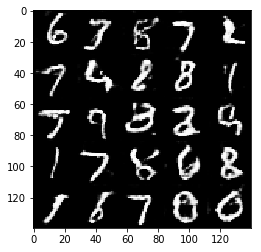

Epoch 2/2... Discriminator Loss: 2.0371... Generator Loss: 0.2743
Epoch 2/2... Discriminator Loss: 0.7513... Generator Loss: 1.1632
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 0.5907
Epoch 2/2... Discriminator Loss: 0.6844... Generator Loss: 1.3448
Epoch 2/2... Discriminator Loss: 1.7581... Generator Loss: 3.4201
Epoch 2/2... Discriminator Loss: 0.6020... Generator Loss: 1.3418
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 0.8602
Epoch 2/2... Discriminator Loss: 1.5321... Generator Loss: 0.4147
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 1.2973
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.7336


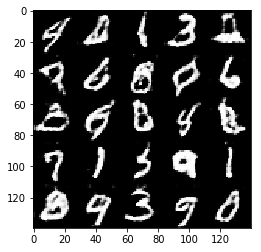

Epoch 2/2... Discriminator Loss: 2.1541... Generator Loss: 0.2630
Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 0.4253
Epoch 2/2... Discriminator Loss: 0.8640... Generator Loss: 1.0592
Epoch 2/2... Discriminator Loss: 0.9718... Generator Loss: 0.7463
Epoch 2/2... Discriminator Loss: 5.0299... Generator Loss: 6.1248
Epoch 2/2... Discriminator Loss: 1.1546... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.2042


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 2.3257... Generator Loss: 6.9433
Epoch 1/1... Discriminator Loss: 0.0771... Generator Loss: 13.4499
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 1.4471
Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 2.5794
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.5060
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 5.4269
Epoch 1/1... Discriminator Loss: 2.1473... Generator Loss: 7.2509
Epoch 1/1... Discriminator Loss: 4.5550... Generator Loss: 0.0834
Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 1.3059


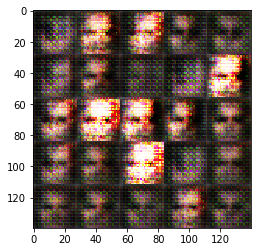

Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 1.4495
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.9646
Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 2.0430
Epoch 1/1... Discriminator Loss: 0.1774... Generator Loss: 2.7703
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 0.4584... Generator Loss: 1.5347
Epoch 1/1... Discriminator Loss: 3.0310... Generator Loss: 7.8276
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 3.9584
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 2.8245


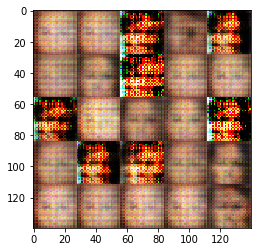

Epoch 1/1... Discriminator Loss: 2.3410... Generator Loss: 5.6904
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 2.4362
Epoch 1/1... Discriminator Loss: 0.3779... Generator Loss: 2.6388
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 0.3202... Generator Loss: 2.3935
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 2.1786
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 1.5937
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 2.4624
Epoch 1/1... Discriminator Loss: 2.1496... Generator Loss: 3.6229


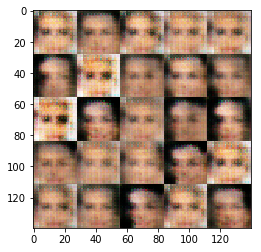

Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.6811
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.6357... Generator Loss: 1.9849
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.7999
Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 1.5635


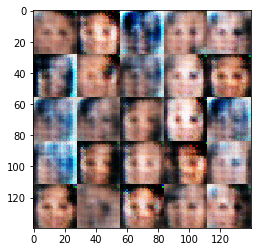

Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 1.8035
Epoch 1/1... Discriminator Loss: 1.5918... Generator Loss: 2.2852
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 1.4308
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.3767
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 1.5210
Epoch 1/1... Discriminator Loss: 1.6344... Generator Loss: 2.5674


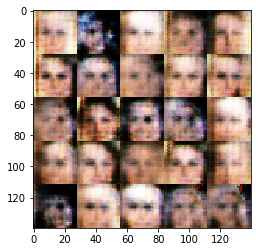

Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 2.4166
Epoch 1/1... Discriminator Loss: 0.7679... Generator Loss: 1.6307
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.5871


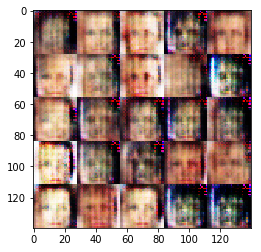

Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.2984
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.6433
Epoch 1/1... Discriminator Loss: 2.2375... Generator Loss: 0.1715
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.3437
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 2.2333


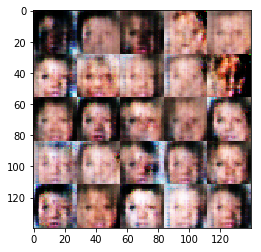

Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.5983... Generator Loss: 2.2666
Epoch 1/1... Discriminator Loss: 1.9909... Generator Loss: 0.3275
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.6519
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.5128
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 1.3499
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.4370


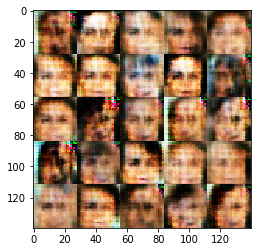

Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 2.0624... Generator Loss: 0.2319
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.2352
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 2.1698


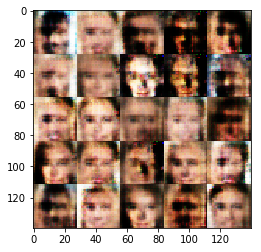

Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 1.5406
Epoch 1/1... Discriminator Loss: 4.1021... Generator Loss: 5.4233
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.4490
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.4485
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 2.5160
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 2.5591
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.3867


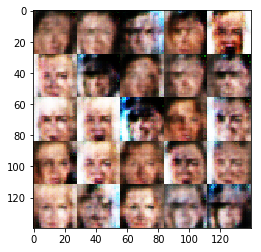

Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.7543... Generator Loss: 3.1496
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.4186
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.5162


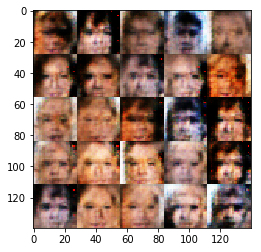

Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 0.7025... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.5063
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.7276
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.5332


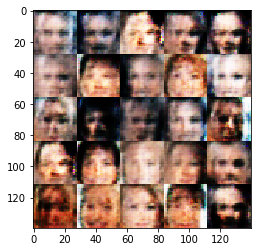

Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 2.3494
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.4145
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.5843
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 1.7575... Generator Loss: 2.3657
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.5442
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 0.5164... Generator Loss: 1.2635


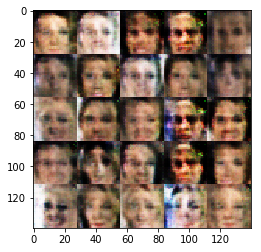

Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 1.2092
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 2.1957
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.1890


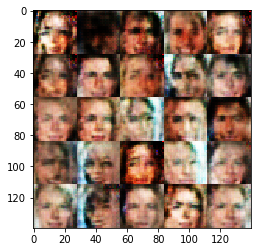

Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.8211
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 2.6561... Generator Loss: 3.2670
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.3264
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 1.8967
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.0207


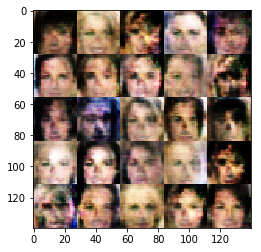

Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.6917
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 1.3681
Epoch 1/1... Discriminator Loss: 2.3527... Generator Loss: 4.4283
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.6127
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.7773


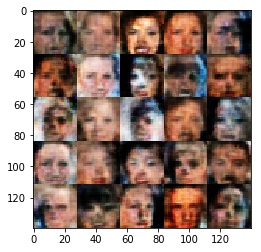

Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 1.2921
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.6607... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.7606


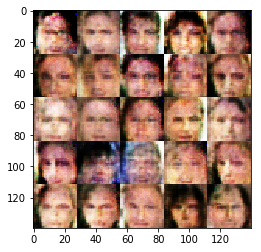

Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 0.6759... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.7691... Generator Loss: 0.2773
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.2710
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 1.0662


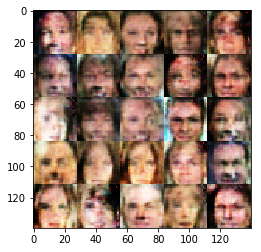

Epoch 1/1... Discriminator Loss: 0.7506... Generator Loss: 1.6903
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 2.1091
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 1.1627
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.7285... Generator Loss: 0.2850


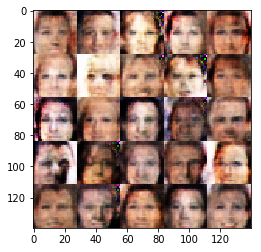

Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 1.9080
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.6678
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 2.3622


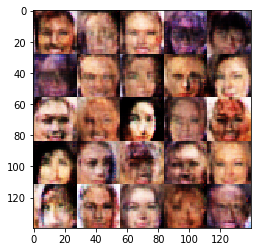

Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 0.5692... Generator Loss: 1.5296
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.3506
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 1.4549
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.6317
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.3726
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.7098


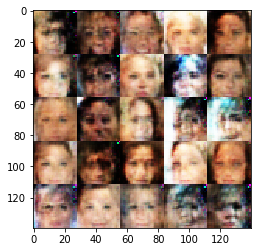

Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.2960
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.5953
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 2.1005
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.1672


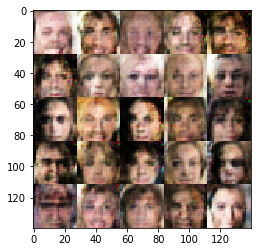

Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 1.8365
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 1.4084
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.9304


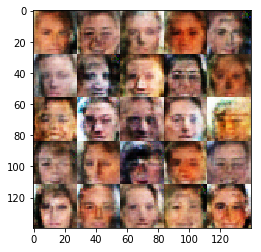

Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 1.3635
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 1.5437
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.7181


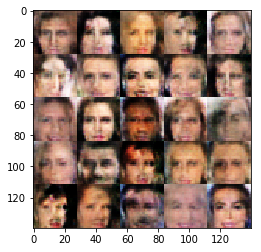

Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.2861
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.4186


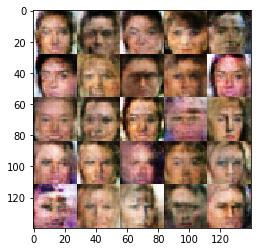

Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 1.2504
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.4494
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 1.6520
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.0068


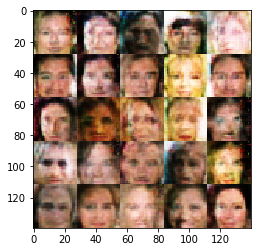

Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 2.0618
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.7156... Generator Loss: 2.9682
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 1.1425


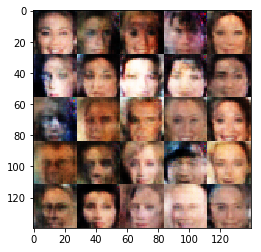

Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.8811... Generator Loss: 0.2263
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.2761


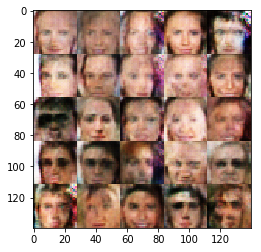

Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.3915
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.2916
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 1.3192
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.3304


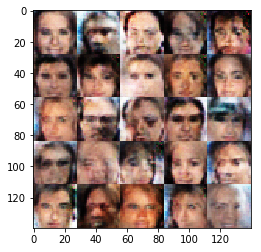

Epoch 1/1... Discriminator Loss: 1.5927... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.4499
Epoch 1/1... Discriminator Loss: 1.6614... Generator Loss: 0.3140
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 1.9356
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.4766


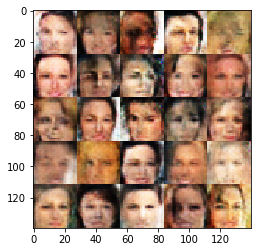

Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 2.0097... Generator Loss: 2.2964
Epoch 1/1... Discriminator Loss: 2.7124... Generator Loss: 0.0928
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 1.3885
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 0.8258


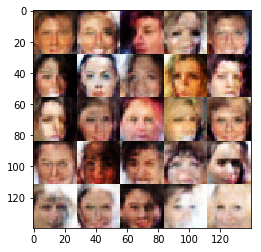

Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.8162


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。